In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, time, urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-28 03:18:45.342086: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", 
     filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
questions, answers = [], []
for sentence in train_data['Q']:    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

for sentence in train_data['A']:    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [6]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [7]:
# Subword text encoder를 사용하여 질문, 답변 데이터로부터 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, 
                                                                      target_vocab_size=2**13)

In [8]:
# 시작 토큰과 종료 토큰에 대한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

print('시작 토큰 번호 :',START_TOKEN, ('종료 토큰 번호 :', END_TOKEN))

시작 토큰 번호 : [8178] ('종료 토큰 번호 :', [8179])


In [9]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [10]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [11]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [12]:
'''
TF dataset을 이용하여 shuffle을 수행하되, 배치 크기로 데이터를 묶는다.
또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 
실제값 시퀀스를 구성한다. 
'''
BATCH_SIZE = 64 
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거
dataset = tf.data.Dataset.from_tensor_slices(({
    'inputs': questions,
    'dec_inputs': answers[:, :-1]}, # 디코더의 입력. 마지막 패딩 토큰 제거
    {'outputs': answers[:, 1:]},    # 맨 처음 시작 토큰 제거
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

2023-11-28 03:18:58.634469: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-11-28 03:18:58.708188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.15GiB deviceMemoryBandwidth: 1.76TiB/s
2023-11-28 03:18:58.709425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b3:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.15GiB deviceMemoryBandwidth: 1.76TiB/s
2023-11-28 03:18:58.709485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-11-28 03:18:58.732804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

In [13]:
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39 임
print(answers[:1][:, 1:]) # 맨 처음 시작토큰이 제거되면서 길이는 역시 39가 됨

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


## PositionalEncoding

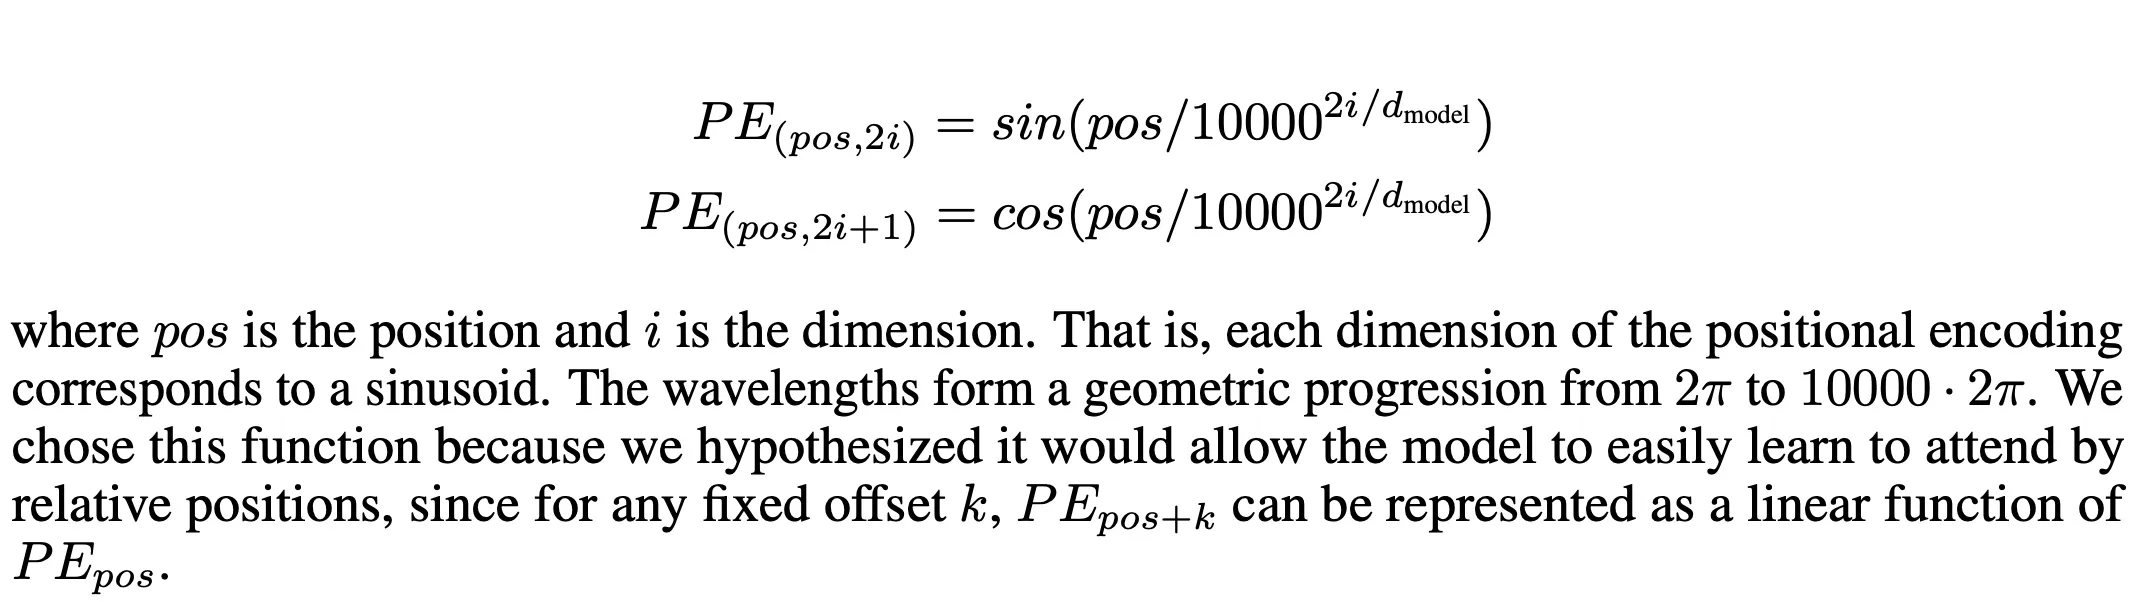
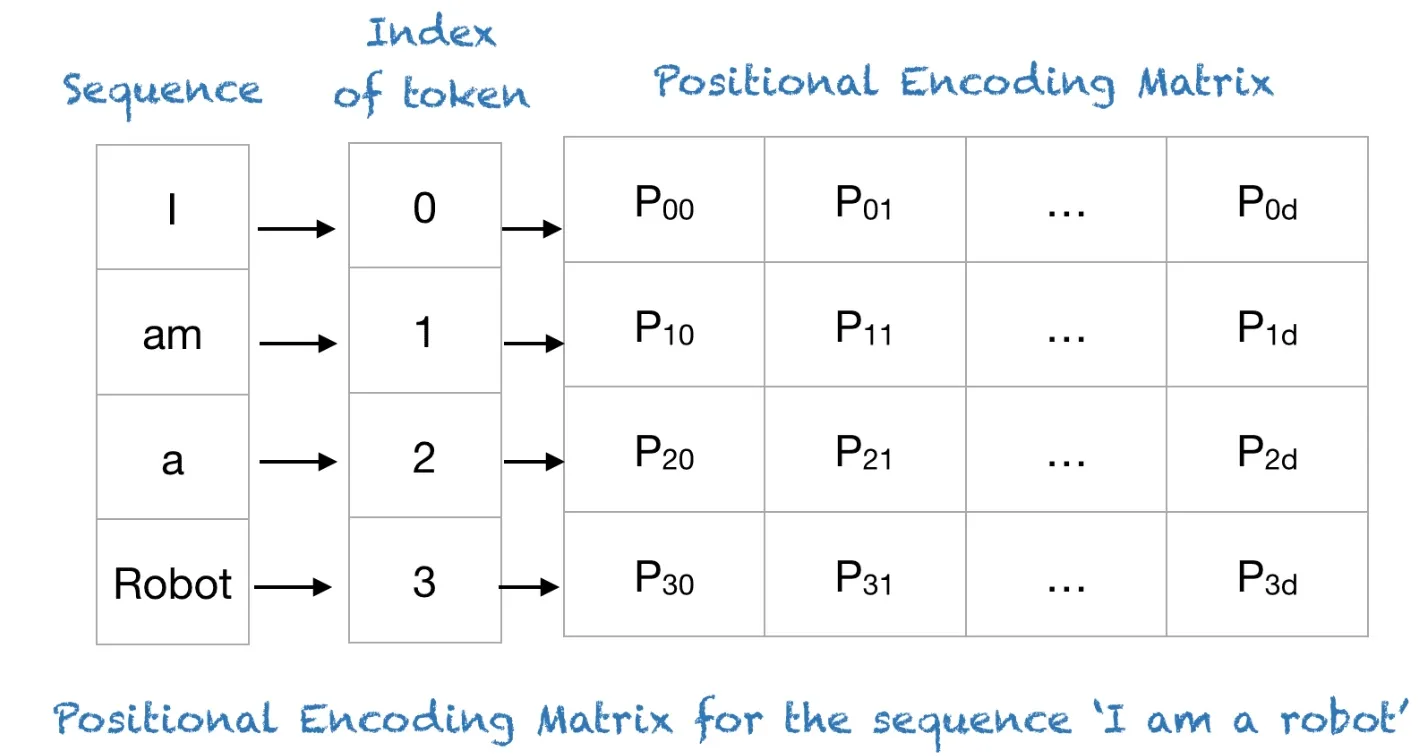
from https://mltalks.medium.com/rotary-embeddings%E8%AE%BA%E6%96%87%E9%98%85%E8%AF%BB-8215471d1f4f

In [14]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    """
    parameter:
    position (int): vecabulary size
    d_model (int): embedding size
    
    return:
    word embedding + positional embedding
    """
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # angles = 1/10000^{2i/d_model}
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        # position/10000^{2i/d_model}
        return position * angles

    def positional_encoding(self, position, d_model):
        # angle_rads size is [position, d_model]
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # [position, 1]
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # [1, d_model]
            d_model=d_model)
        
        # 1.행렬의 모든 행을 선택하라. 2. 0::2는 0번째 열부터 시작하여 한 열마다 한 열을 선택함을 나타냅니다.
        # 1.选择矩阵中的所有行，2. 0::2 表示从第0列开始，每隔一列选择一列
        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        
        # 1.행렬의 모든 행을 선택하라. 2. 1::2는 1번째 열부터 시작하여 한 열마다 한 열을 선택함을 나타냅니다.
        # 1.选择矩阵中的所有行，2. 1::2 表示从第1列开始，每隔一列选择一列
        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        
        # angle_rads를 Tensor로 변환
        # 将angle_rads转换为Tensor
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## MultiHead Attention
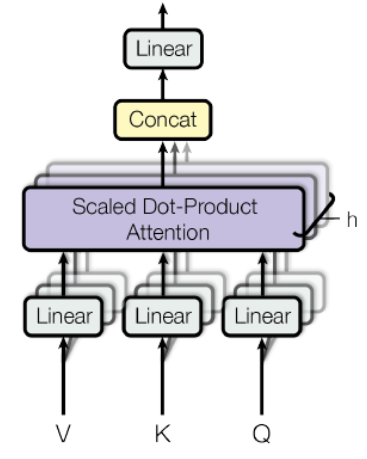

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    '''
    d_model: 각 헤드의 주의력이 나타내는 차원의 총합입니다.
    num_heads: 병렬 주의 계층의 수입니다.
    depth: d_model을 num_heads로 나눈 것과 같은 각 헤드의 차원입니다.
    query_dense, key_dense 및 value_dense: 각각 쿼리(Q), 키(K) 및 값(V) 표시를 생성하는 데 사용되는 전체 연결 계층입니다.
    
    d_model：是每个头的注意力表示的维度的总和。
    num_heads：是并行注意力层的数量。
    depth：是每个头的维度，等于d_model除以num_heads。
    query_dense、key_dense和value_dense：分别是用于创建查询（Q）、键（K）和值（V）表示的全连接层。
    '''
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        """
        마지막 차원을 (num_heads, depth)로 분할합니다.
        모양 바꾸기 (batch_size, num_heads, seq_len, depth)
        分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, seq_len, d_model)
        # k : (batch_size, seq_len, d_model)
        # v : (batch_size, seq_len, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # depth = d_model/num_heads
        # q : (batch_size, num_heads, seq_len_q, depth)
        # k : (batch_size, num_heads, seq_len_k, depth)
        # v : (batch_size, num_heads, seq_len_v, depth)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, seq_len_q, depth)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, seq_len_q, d_model)
        outputs = self.dense(concat_attention)

        return outputs

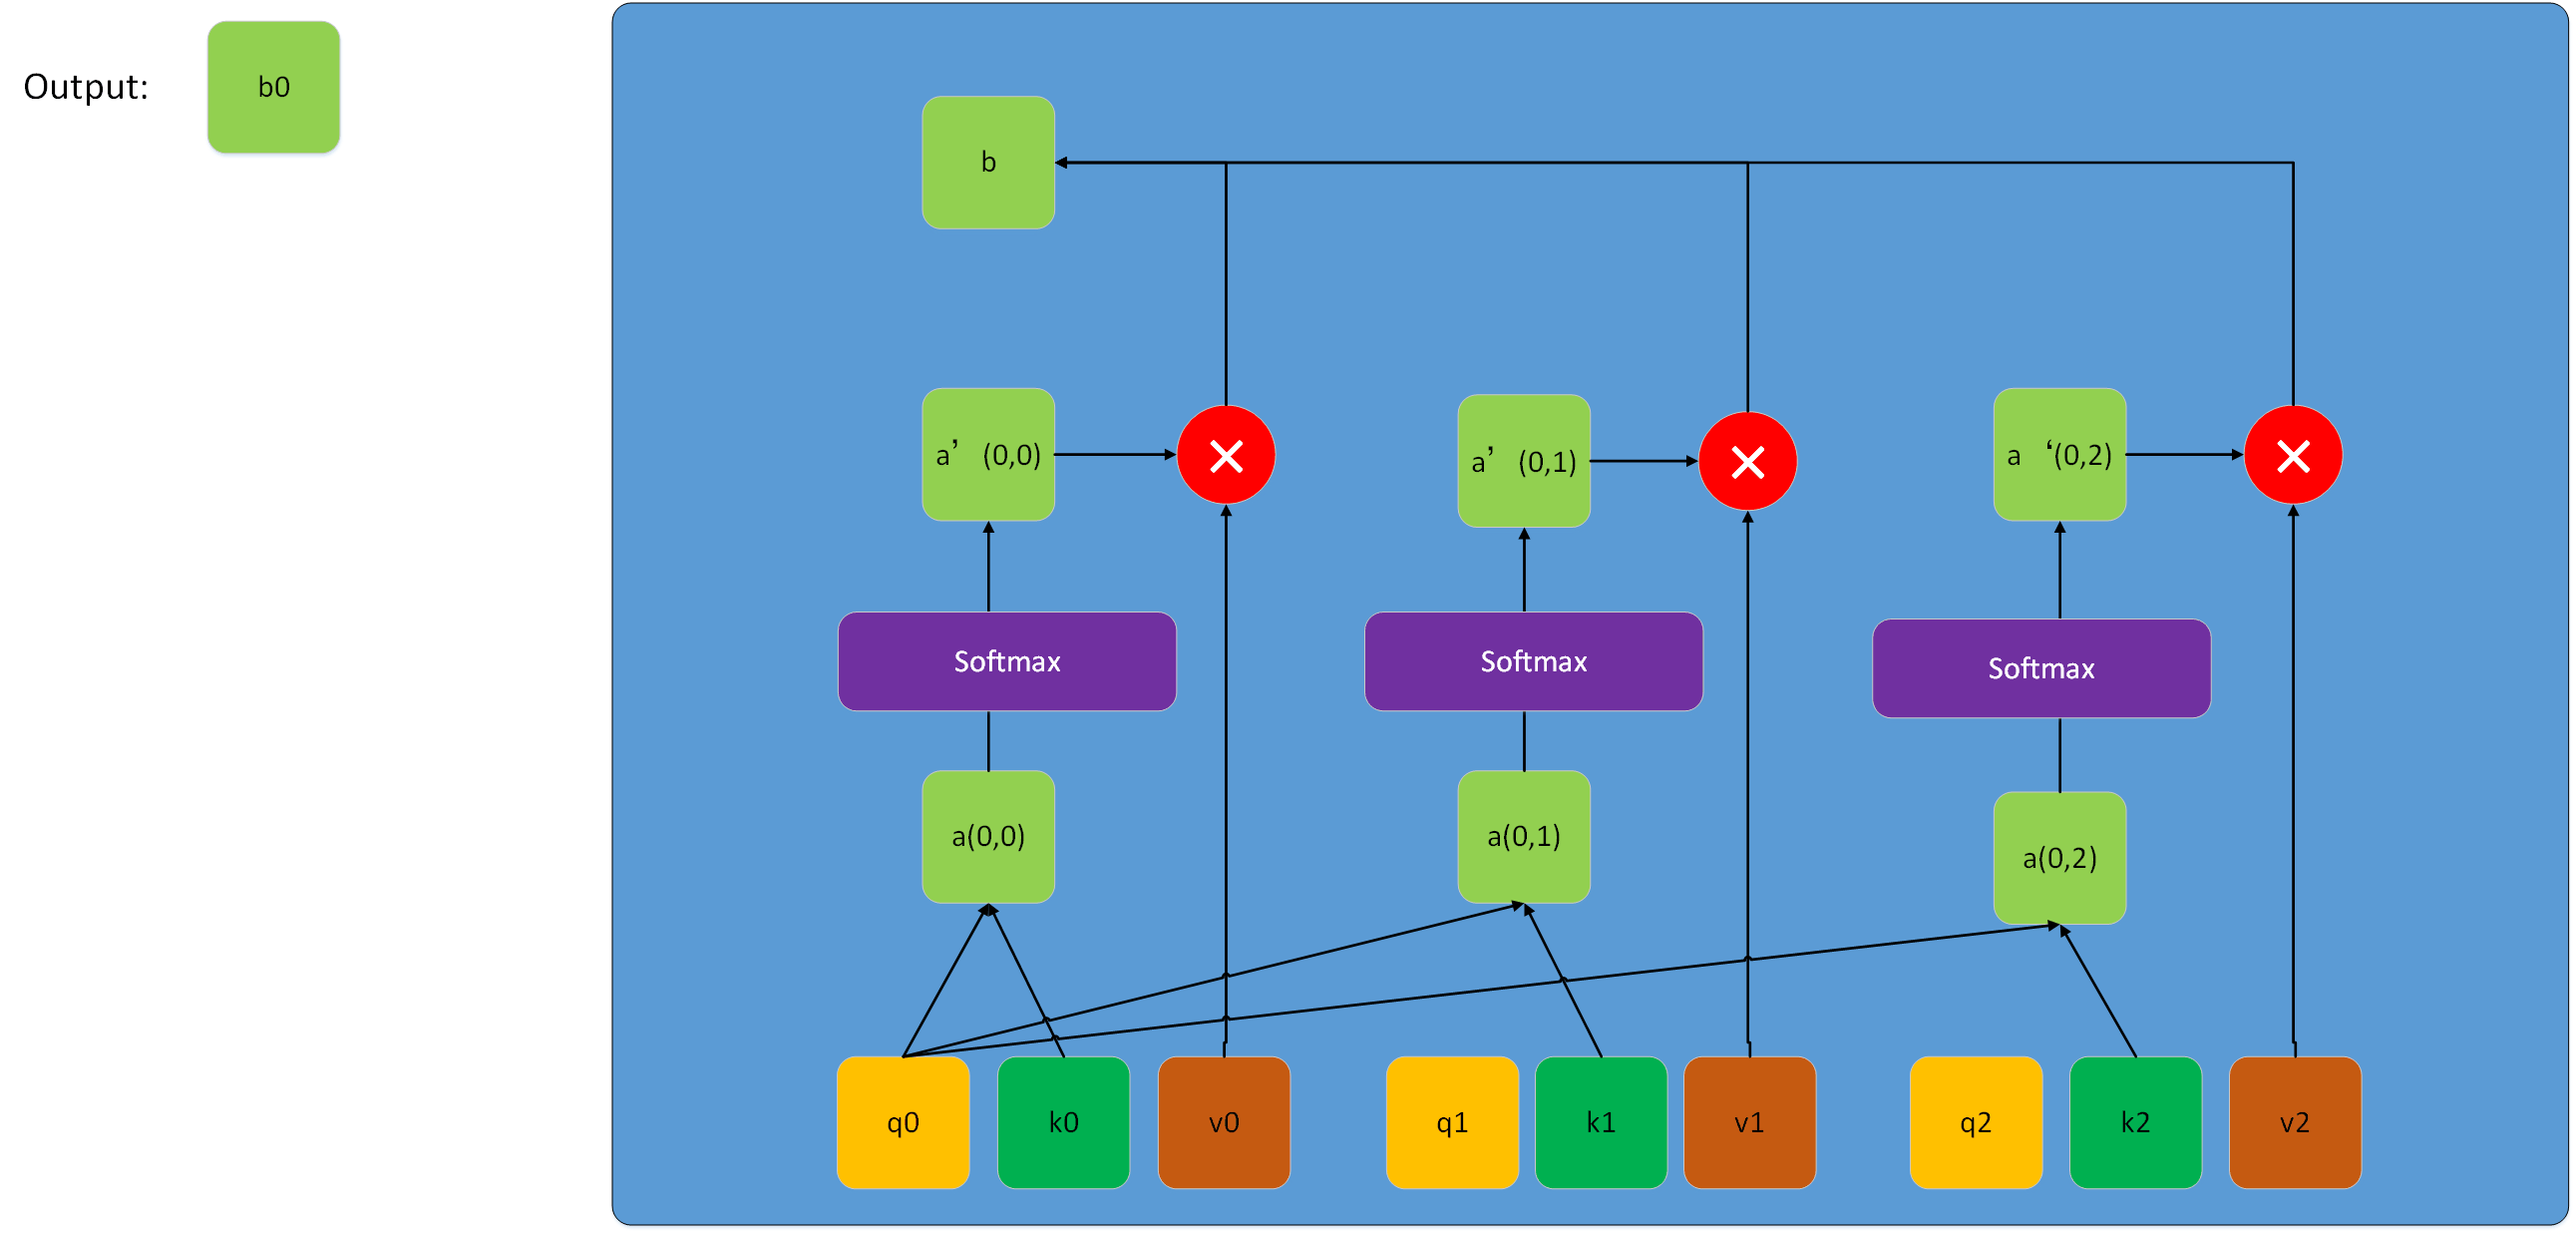

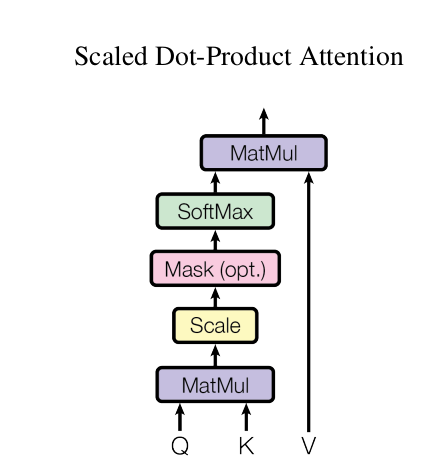
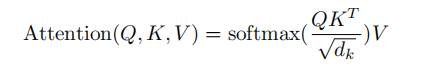

In [16]:
def scaled_dot_product_attention(query, key, value, mask):
    """
    주의력 가중치를 계산하다.
    q, k, v는 반드시 일치하는 사전 차원을 가져야 합니다.
    k, v에는 seq_len_k = seq_len_v와 같은 일치하는 마지막 두 번째 차원이 있어야 합니다.
    mask는 그 종류(채우기 또는 전향)에 따라 모양이 다르지만,
    그러나 mask는 합을 맞추기 위해 방송 변환을 할 수 있어야 합니다.

    parameter:
        q: 요청한 모양 == (..., .., seq_len_q, depth)
        k: 주 키 모양 == (..., .., seq_len_k, depth)
        v: 수치의 모양 == (..., .., seq_len_v, depth_v)
        mask: 모양을 변환할 수 있는 Float 텐서
              (..., .., seq_len_q, seq_len_k)。기본값은 None입니다.

    return:
        출력, 주의력 가중치
        
         计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    parameter:
        q: 请求的形状 == (..., seq_len_q, depth)
        k: 主键的形状 == (..., seq_len_k, depth)
        v: 数值的形状 == (..., seq_len_v, depth_v)
        mask: Float 张量，其形状能转换成
              (..., seq_len_q, seq_len_k)。默认为None。

    return:
        输出，注意力权重
    """
    
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数   （对注意力矩阵每一行归一化，
    # 则每个字的注意力向量一行，就是与其余字的相关程度，和为1）
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

## Encoder
<img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/Transformer-neural-network-12.png" width=256 height=256 />

In [17]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, 
                                dropout=dropout, name="encoder_layer_{}".format(i),
                               )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [18]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder
[image.png]
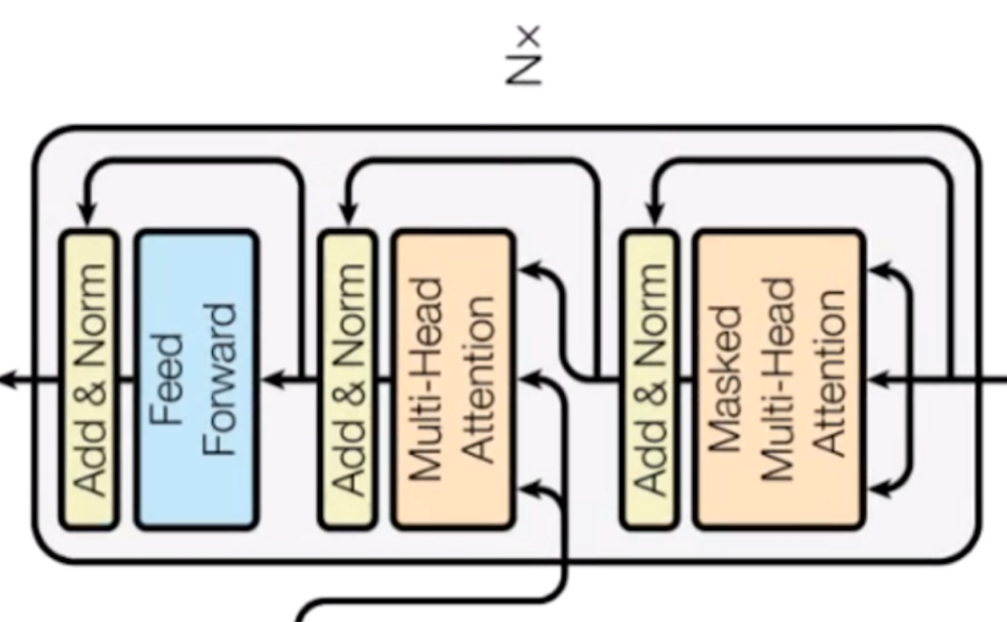

In [19]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [20]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

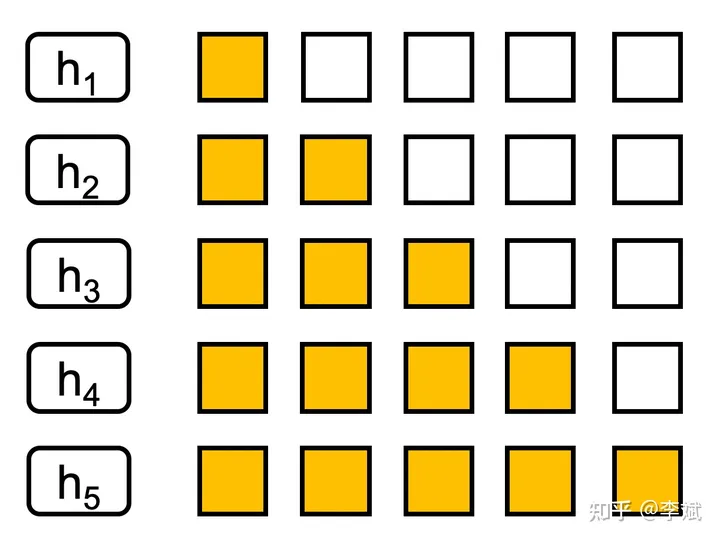
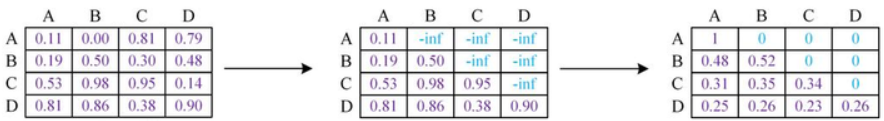

In [21]:
def create_padding_mask(x):
    # x에 0이 포함되어 있는지 여부 판단
    # 判断x中是否包含0
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    
    # 전향 마스크와 채우기 마스크를 결합하여 주의력을 계산할 때 모델이 미래의 단어와 채우기 단어를 무시합니다.
    # 前瞻掩码和填充掩码结合起来，这样在计算注意力时，模型将忽略未来的词汇和填充的词汇
    return tf.maximum(look_ahead_mask, padding_mask)

In [23]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [24]:
tf.keras.backend.clear_session()

# 하이퍼 파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

In [25]:
model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    dff=DFF,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [27]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [28]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [29]:
EPOCHS = 150
model.fit(dataset, epochs=EPOCHS)

Epoch 1/150


2023-11-28 03:19:06.733294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-11-28 03:19:06.780682: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2023-11-28 03:19:07.860264: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  2/185 [..............................] - ETA: 17s - loss: 1.5502 - accuracy: 0.0000e+00  

2023-11-28 03:19:09.273794: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-11-28 03:19:09.273859: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


185/185 [==============================] - 20s 74ms/step - loss: 1.4460 - accuracy: 0.0236
Epoch 2/150
185/185 [==============================] - 13s 72ms/step - loss: 1.1751 - accuracy: 0.0495
Epoch 3/150
185/185 [==============================] - 14s 73ms/step - loss: 1.0025 - accuracy: 0.0506
Epoch 4/150
185/185 [==============================] - 13s 72ms/step - loss: 0.9281 - accuracy: 0.0544
Epoch 5/150
185/185 [==============================] - 13s 71ms/step - loss: 0.8708 - accuracy: 0.0576
Epoch 6/150
185/185 [==============================] - 13s 72ms/step - loss: 0.8106 - accuracy: 0.0618
Epoch 7/150
185/185 [==============================] - 13s 73ms/step - loss: 0.7444 - accuracy: 0.0678
Epoch 8/150
185/185 [==============================] - 12s 66ms/step - loss: 0.6715 - accuracy: 0.0754
Epoch 9/150
185/185 [==============================] - 13s 72ms/step - loss: 0.5925 - accuracy: 0.0841
Epoch 10/150
185/185 [==============================] - 13s 72ms/step - loss: 0.5103 

Epoch 80/150
185/185 [==============================] - 13s 72ms/step - loss: 0.0029 - accuracy: 0.1743
Epoch 81/150
185/185 [==============================] - 13s 72ms/step - loss: 0.0028 - accuracy: 0.1743
Epoch 82/150
185/185 [==============================] - 13s 72ms/step - loss: 0.0026 - accuracy: 0.1744
Epoch 83/150
185/185 [==============================] - 13s 72ms/step - loss: 0.0026 - accuracy: 0.1744
Epoch 84/150
185/185 [==============================] - 13s 72ms/step - loss: 0.0026 - accuracy: 0.1743
Epoch 85/150
185/185 [==============================] - 13s 72ms/step - loss: 0.0028 - accuracy: 0.1743
Epoch 86/150
185/185 [==============================] - 12s 64ms/step - loss: 0.0025 - accuracy: 0.1744
Epoch 87/150
185/185 [==============================] - 11s 60ms/step - loss: 0.0024 - accuracy: 0.1744
Epoch 88/150
185/185 [==============================] - 11s 60ms/step - loss: 0.0024 - accuracy: 0.1744
Epoch 89/150
185/185 [==============================] - 11s 61ms

In [30]:
def preprocess_sentence(sentence):
    # 단어와 구두점 사이에 공백 추가.
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [31]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence) # 입력 문장에 대한 전처리 수행

    # 입력 문장에 시작 토큰과 종료 토큰을 추가
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 예측
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        predictions = predictions[:, -1:, :] # 현재 시점의 예측 단어를 받아옴
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]): break

        # 현재 시점의 예측 단어를 output에 연결되고 다음 루프에서 디코더의 입력이 됨
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0) # 단어 예측이 모두 끝났다면 output을 리턴

In [32]:
def predict(sentence):
    prediction = evaluate(sentence)

    # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
    # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [33]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 솔직한 마음으로 다가가보세요 .
